# EMIT

## Install package with EMIT dependecies 

EMIT requires the `netcdf4` package to read the products.

```
pip install git+https://github.com/spaceml-org/georeader#egg=georeader[emit]
```

## Download an EMIT image

In [1]:
from georeader.readers import emit
from georeader.readers import download_utils
import os

dir_emit_files = "emit_database/raw"
os.makedirs(dir_emit_files, exist_ok=True)
# link = 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL1BRAD.001/EMIT_L1B_RAD_001_20220828T051941_2224004_006/EMIT_L1B_RAD_001_20220828T051941_2224004_006.nc'
link = 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL1BRAD.001/EMIT_L1B_RAD_001_20220827T060753_2223904_013/EMIT_L1B_RAD_001_20220827T060753_2223904_013.nc'
file_save = os.path.join(dir_emit_files, os.path.basename(link))

emit.download_product(link, file_save)

File emit_database/raw/EMIT_L1B_RAD_001_20220827T060753_2223904_013.nc exists. It won't be downloaded again


/home/gonzalo/mambaforge/envs/marss2_vm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'emit_database/raw/EMIT_L1B_RAD_001_20220827T060753_2223904_013.nc'

## Create and inspec emit object

EMIT objects let you open an EMIT nc file without loading the content of the file in memory. The object in the cell below has 285 spectral bands. For the API description of the EMIT class see [the emit module](https://github.com/spaceml-org/georeader/blob/main/georeader/readers/emit.py). Since the object follows the API of georeader, you can read from the rasters using the functions from the [read](https://github.com/spaceml-org/georeader/blob/main/georeader/read.py) module.

In [2]:
# file_save = "emit_database/EMIT_L1B_RAD_001_20220827T060753_2223904_013.nc"
ei = emit.EMITImage(file_save)
ei

 
         File: emit_database/raw/EMIT_L1B_RAD_001_20220827T060753_2223904_013.nc
         Transform: | 0.00,-0.00, 61.16|
|-0.00,-0.00, 36.83|
| 0.00, 0.00, 1.00|
         Shape: (285, 2007, 2239)
         Resolution: (0.0005422325202530942, 0.0005422325202530942)
         Bounds: (61.1592142222353, 35.74201728362127, 62.3732728350893, 36.8302779517758)
         CRS: EPSG:4326
         units: uW/cm^2/SR/nm
        

In [3]:
ei.nc_ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    ncei_template_version: NCEI_NetCDF_Swath_Template_v2.0
    summary: The Earth Surface Mineral Dust Source Investigation (EMIT) is an Earth Ventures-Instrument (EVI-4) Mission that maps the surface mineralogy of arid dust source regions via imaging spectroscopy in the visible and short-wave infrared (VSWIR). Installed on the International Space Station (ISS), the EMIT instrument is a Dyson imaging spectrometer that uses contiguous spectroscopic measurements from 410 to 2450 nm to resolve absoprtion features of iron oxides, clays, sulfates, carbonates, and other dust-forming minerals. During its one-year mission, EMIT will observe the sunlit Earth's dust source regions that occur within +/-52° latitude and produce maps of the source regions that can be used to improve forecasts of the role of mineral dust in the radiative forcing (warming or cooling) of the atmosphere.\n\nThis file contains L1B at-s

In [4]:
ei.wavelengths

array([ 381.00558,  388.4092 ,  395.81583,  403.2254 ,  410.638  ,
        418.0536 ,  425.47214,  432.8927 ,  440.31726,  447.7428 ,
        455.17035,  462.59888,  470.0304 ,  477.46292,  484.89743,
        492.33292,  499.77142,  507.2099 ,  514.6504 ,  522.0909 ,
        529.5333 ,  536.9768 ,  544.42126,  551.8667 ,  559.3142 ,
        566.7616 ,  574.20905,  581.6585 ,  589.108  ,  596.55835,
        604.0098 ,  611.4622 ,  618.9146 ,  626.36804,  633.8215 ,
        641.2759 ,  648.7303 ,  656.1857 ,  663.6411 ,  671.09753,
        678.5539 ,  686.0103 ,  693.4677 ,  700.9251 ,  708.38354,
        715.84094,  723.2993 ,  730.7587 ,  738.2171 ,  745.6765 ,
        753.1359 ,  760.5963 ,  768.0557 ,  775.5161 ,  782.97754,
        790.4379 ,  797.89935,  805.36176,  812.8232 ,  820.2846 ,
        827.746  ,  835.2074 ,  842.66986,  850.1313 ,  857.5937 ,
        865.0551 ,  872.5176 ,  879.98004,  887.44147,  894.90393,
        902.3664 ,  909.82886,  917.2913 ,  924.7538 ,  932.21

In [5]:
import geopandas as gpd

gpd.GeoDataFrame(geometry=[ei.footprint()],
                 crs=ei.crs).explore()

## Load RGB

Select the RGB bands, we see that the raster has only 3 channels now (see Shape in the output of the cell below). The `ei` object has an attribute called `wavelengths` with the central wavelength of the hyperspectral band.

In [6]:
import numpy as np
wavelengths_read = np.array([640, 550, 460])

bands_read = np.argmin(np.abs(wavelengths_read[:, np.newaxis] - ei.wavelengths), axis=1).tolist()
ei_rgb = ei.read_from_bands(bands_read)
ei_rgb

 
         File: emit_database/raw/EMIT_L1B_RAD_001_20220827T060753_2223904_013.nc
         Transform: | 0.00,-0.00, 61.16|
|-0.00,-0.00, 36.83|
| 0.00, 0.00, 1.00|
         Shape: (3, 2007, 2239)
         Resolution: (0.0005422325202530942, 0.0005422325202530942)
         Bounds: (61.1592142222353, 35.74201728362127, 62.3732728350893, 36.8302779517758)
         CRS: EPSG:4326
         units: uW/cm^2/SR/nm
        

In [7]:
bands_read

[35, 23, 11]

In [8]:
ei_rgb.wavelengths

array([641.2759 , 551.8667 , 462.59888], dtype=float32)

In [9]:
ei_rgb.window_raw

Window(col_off=0, row_off=0, width=1242, height=1280)

In [10]:
ei_rgb.glt.values[:, ei_rgb.valid_glt]

array([[1241, 1242, 1240, ...,    1,    2,    1],
       [   1,    1,    1, ..., 1280, 1280, 1280]], dtype=int32)

In [11]:
ei_rgb._bounds_indexes_raw()

(1, 1, 1242, 1280)

In [12]:
ei_rgb.glt_relative[:, ei_rgb.valid_glt]

array([[1240, 1241, 1239, ...,    0,    1,    0],
       [   0,    0,    0, ..., 1279, 1279, 1279]], dtype=int32)

In [13]:
ei_rgb_local = ei_rgb.load()
ei_rgb_local

 
         Transform: | 0.00,-0.00, 61.16|
|-0.00,-0.00, 36.83|
| 0.00, 0.00, 1.00|
         Shape: (3, 2007, 2239)
         Resolution: (0.0005422325202530942, 0.0005422325202530942)
         Bounds: (61.1592142222353, 35.74201728362127, 62.3732728350893, 36.8302779517758)
         CRS: EPSG:4326
         fill_value_default: -9999.0
        

<Axes: >

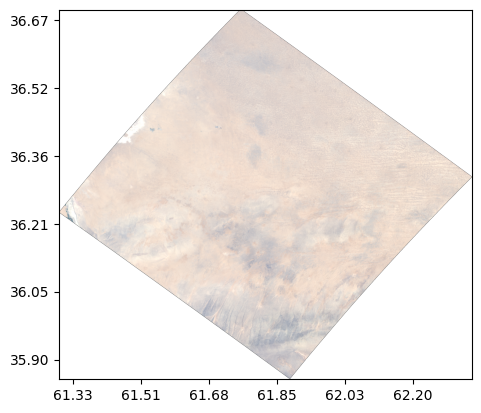

In [14]:
from georeader.plot import show

show((ei_rgb_local / 12).clip(0,1), 
     mask=ei_rgb_local.values == ei_rgb_local.fill_value_default)

## Reproject to UTM


In [22]:
import georeader

crs_utm = georeader.get_utm_epsg(ei.footprint("EPSG:4326"))
emit_image_utm = ei.to_crs(crs_utm)
emit_image_utm_rgb = emit_image_utm.read_from_bands(bands_read)
emit_image_utm_rgb_local = emit_image_utm_rgb.load()

emit_image_utm_rgb_local

 
         Transform: | 60.00, 0.00, 333546.51|
| 0.00,-60.00, 4077625.88|
| 0.00, 0.00, 1.00|
         Shape: (3, 2036, 1844)
         Resolution: (60.0, 60.0)
         Bounds: (333546.5136802632, 3955465.8769401284, 444186.5136802632, 4077625.8769401284)
         CRS: EPSG:32641
         fill_value_default: -9999.0
        

<Axes: >

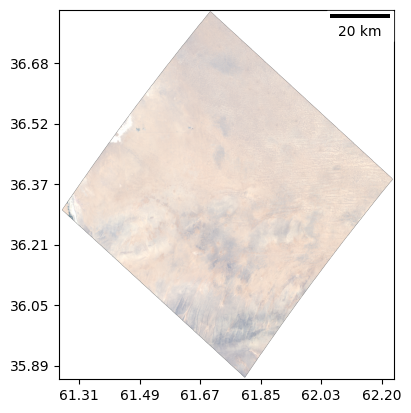

In [23]:
show((emit_image_utm_rgb_local / 12).clip(0,1), 
     mask=emit_image_utm_rgb_local.values == emit_image_utm_rgb_local.fill_value_default,
     add_scalebar=True)

<Axes: title={'center': 'Elevation'}>

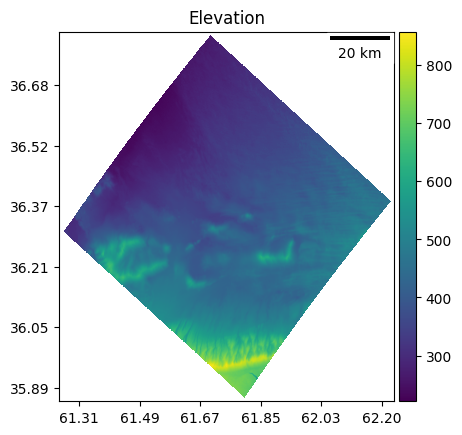

In [24]:
show(emit_image_utm.elevation(), add_colorbar_next_to=True, add_scalebar=True,
     mask=True,title="Elevation")

## Subset EMIT image

In [27]:
from georeader import read

point_tup = (61.28, 36.21)
ei_subset = read.read_from_center_coords(emit_image_utm_rgb, point_tup, 
                                         shape=(200,200),crs_center_coords="EPSG:4326")
ei_subset_local = ei_subset.load()
ei_subset_local

 
         Transform: | 60.00, 0.00, 339366.51|
| 0.00,-60.00, 4014625.88|
| 0.00, 0.00, 1.00|
         Shape: (3, 200, 200)
         Resolution: (60.0, 60.0)
         Bounds: (339366.5136802632, 4002625.8769401284, 351366.5136802632, 4014625.8769401284)
         CRS: EPSG:32641
         fill_value_default: -9999.0
        

<Axes: >

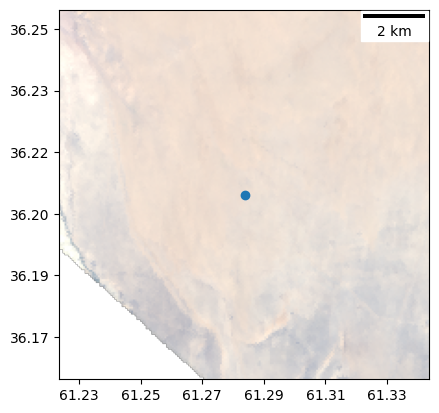

In [33]:
from georeader.plot import add_shape_to_plot
from shapely.geometry import Point

ax = show((ei_subset_local / 12).clip(0,1),
          mask=ei_subset_local.values == ei_rgb_local.fill_value_default,
         add_scalebar=True)
add_shape_to_plot(Point(*point_tup),crs_shape="EPSG:4326",
                  crs_plot=ei_subset_local.crs, ax=ax)

## Load image non-orthorectified

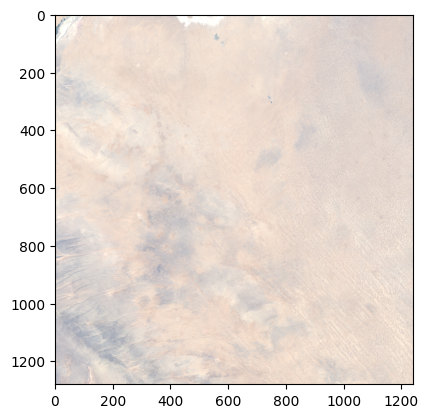

In [35]:
import matplotlib.pyplot as plt

ei_rgb_raw = ei_rgb.load_raw(transpose=False)
plt.imshow((ei_rgb_raw/12).clip(0,1))

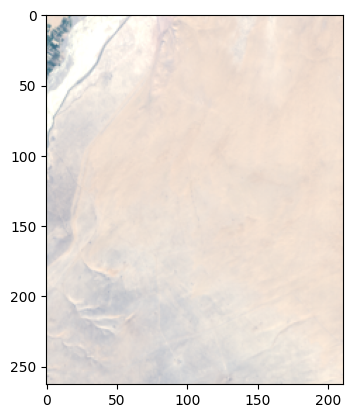

In [36]:
ei_rgb_subset = ei_subset.load_raw(transpose=False)
plt.imshow((ei_rgb_subset/12).clip(0,1))

## Load metadata

Metadata is stored in a separated file (with suffix `_OBS_` instead of `_RAD_`). In metadata we have the following variables:

In [37]:
emit_image_utm.observation_bands

array(['Path length (sensor-to-ground in meters)',
       'To-sensor azimuth (0 to 360 degrees CW from N)',
       'To-sensor zenith (0 to 90 degrees from zenith)',
       'To-sun azimuth (0 to 360 degrees CW from N)',
       'To-sun zenith (0 to 90 degrees from zenith)',
       'Solar phase (degrees between to-sensor and to-sun vectors in principal plane)',
       'Slope (local surface slope as derived from DEM in degrees)',
       'Aspect (local surface aspect 0 to 360 degrees clockwise from N)',
       'Cosine(i) (apparent local illumination factor based on DEM slope and aspect and to sun vector)',
       'UTC Time (decimal hours for mid-line pixels)',
       'Earth-sun distance (AU)'], dtype=object)

<Axes: title={'center': 'Solar Zenith Angle'}>

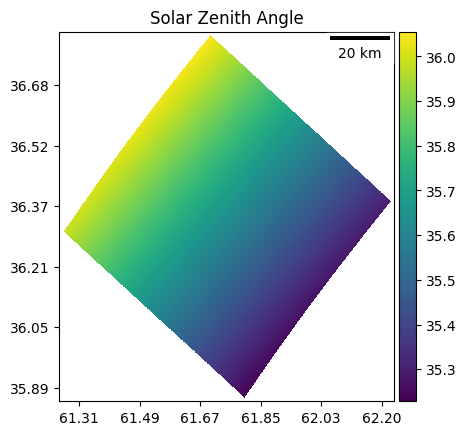

In [38]:
show(emit_image_utm.sza(), add_colorbar_next_to=True, add_scalebar=True,
     mask=True,title="Solar Zenith Angle")

<Axes: title={'center': 'Viewing Zenith Angle'}>

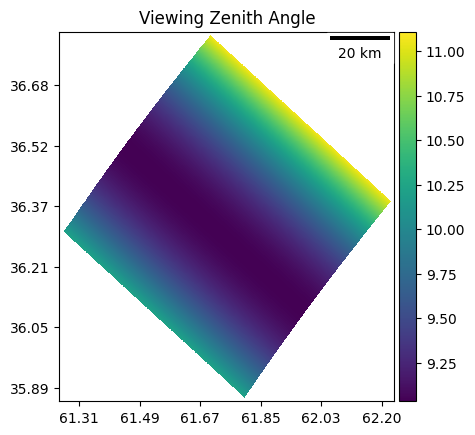

In [39]:
show(emit_image_utm.vza(), add_colorbar_next_to=True, add_scalebar=True,
     mask=True,title="Viewing Zenith Angle")

<Axes: title={'center': "'Path length (sensor-to-ground in meters)'"}>

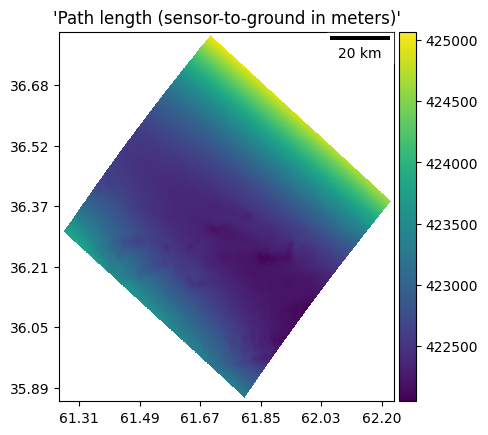

In [40]:
show(emit_image_utm.observation('Path length (sensor-to-ground in meters)'), 
     add_colorbar_next_to=True, add_scalebar=True,
     mask=True,title="'Path length (sensor-to-ground in meters)'")

<Axes: title={'center': "'Path length (sensor-to-ground in meters)'"}>

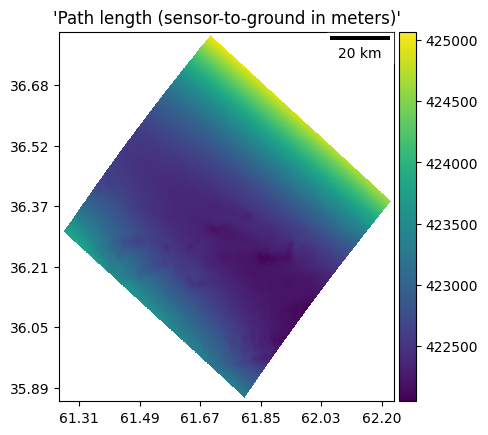

In [41]:
show(emit_image_utm.observation('Path length (sensor-to-ground in meters)'), 
     add_colorbar_next_to=True, add_scalebar=True,
     mask=True,title="'Path length (sensor-to-ground in meters)'")